# Exploratory Data Analysis

The data is from the [kaggle copetition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

<p align="center">
    <img src="img/description.png"  width="80%" height="20%">
</p>

### Dataset Description
File descriptions
 * train.csv - the training set.
 * test.csv - the test set.
 * data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here.

 #### EDA:

 **Target Variable**
 
 `SalePrice` is the variable we need to predict. So let's do some analysis on this variable first.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 65 
from scipy import stats
from scipy.stats import skew
from plot_tools import plot_distribution, plot_corration_map
from bayesian_opt import Optimizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from skopt.space import Integer, Real

/var/folders/0m/mtf6psc91_l02bjt_n2nd7bh0000gn/T/ipykernel_3441/2739651402.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [2]:
df_train = pd.read_csv('data/train.csv')
display(df_train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.drop("Id", axis=1, inplace=True)

In [4]:
print("Skewness: %f" % df_train['SalePrice'].skew())

Skewness: 1.882876


/Users/cristianooliveira/Documents/eda/plot_tools.py:65: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[var], color='r', fit=norm, ax=axs[0], hist=False, fit_kws={"color":"red"});


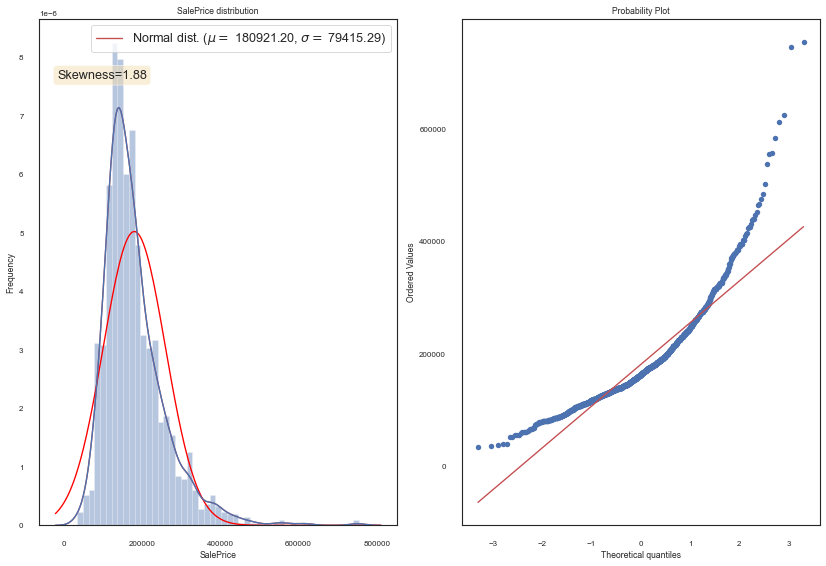

In [5]:

plot_distribution(df_train, 'SalePrice')

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

Log-transformation of the target variable

/Users/cristianooliveira/Documents/eda/plot_tools.py:65: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[var], color='r', fit=norm, ax=axs[0], hist=False, fit_kws={"color":"red"});


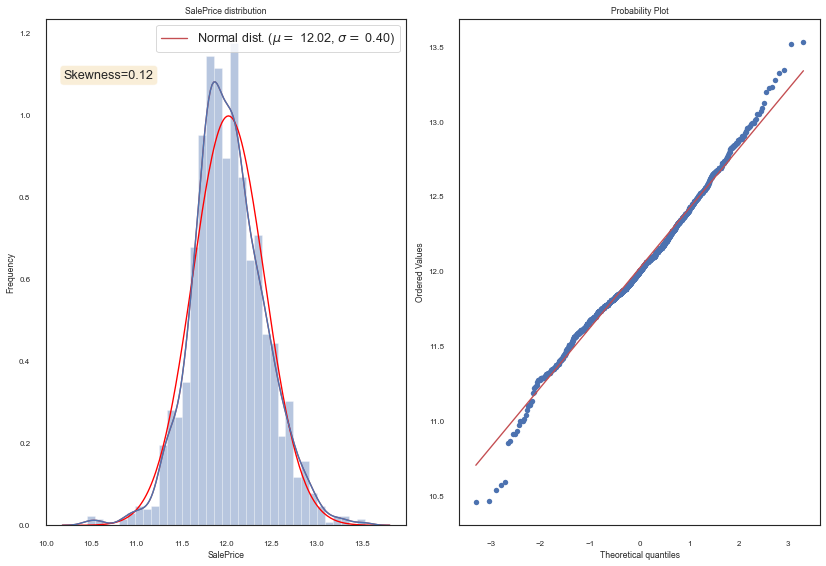

In [6]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
plot_distribution(df_train, 'SalePrice')

### Features engineering

In [7]:
def get_missing(X: pd.DataFrame) -> None:
    missing_rate = (X.isnull().sum() / len(X)) * 100
    missing_rate = missing_rate.drop(
        missing_rate[missing_rate == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio': missing_rate})
    return missing_data

missing_data = get_missing(df_train)
display(missing_data.head(20))

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
MasVnrType,59.726027
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


Alley: Type of alley access to property

* NA: 	No alley access
		
BsmtQual: Evaluates the height of the basement

* NA:	No Basement
		
BsmtCond: Evaluates the general condition of the basement

* NA:	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

* NA:	No Basement
	
BsmtFinType1: Rating of basement finished area

* NA:	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

* NA:	No Basement

FireplaceQu: Fireplace quality
* NA:	No Fireplace
		
GarageType: Garage location
* NA:	No Garage
	
GarageFinish: Interior finish of the garage
* NA:	No Garage

GarageQual: Garage quality
* NA:	No Garage
		
GarageCond: Garage condition
* NA:	No Garage

PoolQC: Pool quality
* NA:	No Pool
		
Fence: Fence quality
* NA:	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
* NA:	None



In [8]:
variables_where_null_is_0 = [
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 
                'GarageCond', 'PoolQC', 'Fence'
            ]
values = {"Functional": "Typ", "Alley": "None", "MiscFeature": "no_misc_feature", **{v:0 for v in variables_where_null_is_0}}
df_train.fillna(value=values, inplace=True)

In [9]:
missing_data = get_missing(df_train)
display(missing_data.head(20))

,Missing Ratio
MasVnrType,59.726027
LotFrontage,17.739726
GarageYrBlt,5.547945
MasVnrArea,0.547945
Electrical,0.068493


In [10]:
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.sort_values(by=['Skew'], ascending=False).head(10))

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [11]:
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(
    lambda x: skew(x.dropna()))  # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df_train[skewed_feats] = np.log1p(df_train[skewed_feats])

In [12]:
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.sort_values(by=['Skew'], ascending=False).head(10))

,Skew
PoolArea,14.348342
3SsnPorch,7.727026
LowQualFinSF,7.452650
MiscVal,5.165390
BsmtHalfBath,3.929022
KitchenAbvGr,3.865437
ScreenPorch,3.147171
BsmtFinSF2,2.521100
EnclosedPorch,2.110104
OverallCond,0.692355


In [13]:
df_train = pd.get_dummies(df_train)
df_train = df_train.fillna(df_train.mean())
missing_data = get_missing(df_train)
display(missing_data.head(20))

,Missing Ratio


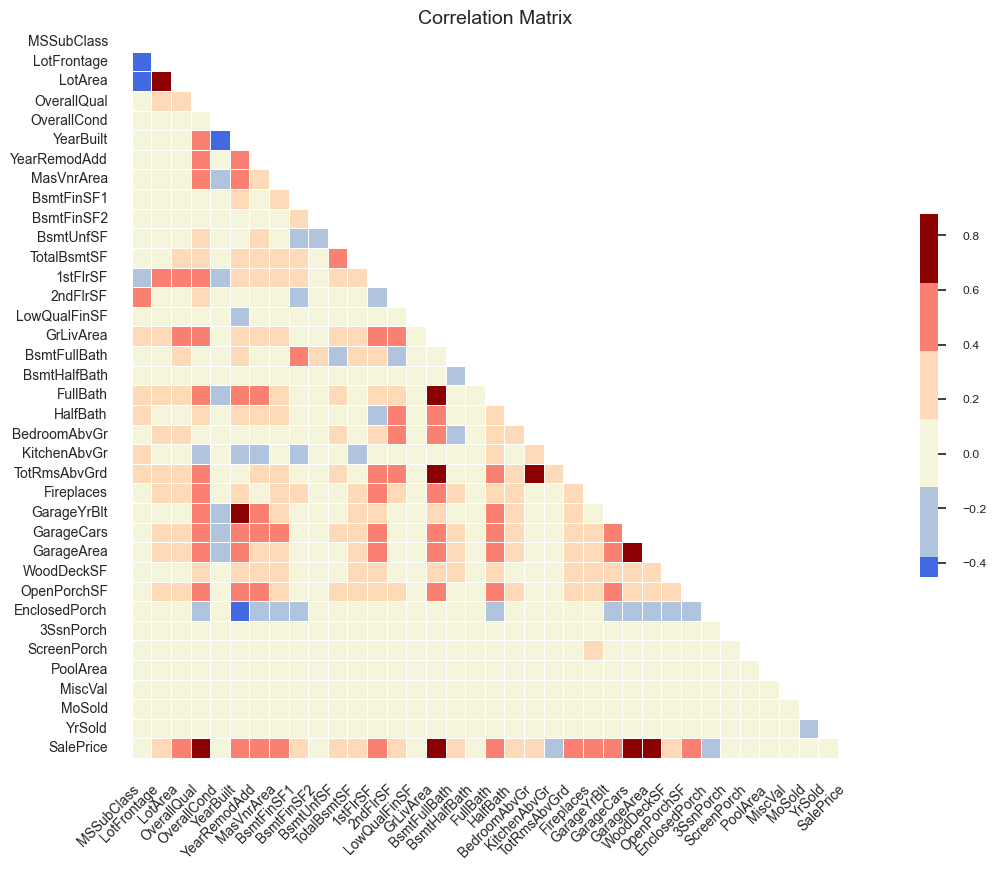

In [14]:
plot_corration_map(df_train[numeric_feats])

### Modeling

In [16]:
y = df_train.SalePrice.values.astype(float)
X = df_train.reset_index(drop=True).drop(['SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=0)

dict_models = {
'lasso': {
    'model': Lasso(),
    'space': [Real(0, 0.02, name='alpha')]},

'rf': {
    'space': [Integer(100, 1000, name='n_estimators'),
                Integer(2, 100, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf')
                ],
    'model': RandomForestRegressor()}
}

for model in dict_models:
    model_name = model
    space = dict_models[model]['space']
    model = dict_models[model]['model']
    optimizer = Optimizer(space=space, model=model,
                            model_name=model_name, n_calls=20)

    optimizer.find_optimal_params(X=X_train, y=y_train)
    best_model = optimizer.best_model.fit(X_train, y_train.ravel())
    y_pred = best_model.predict(X_test)
    print(
        f"Test accuracy: cor: {np.corrcoef(y_pred, y_test)[0,1]:.4f}, mse: {np.mean((y_pred - y_test)**2):.4f}")


Wait: Finding the best parameters .....


/Users/cristianooliveira/Documents/eda/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e+00, tolerance: 1.521e-02
  model = cd_fast.enet_coordinate_descent(


Otimization had done ...
Trainin acuracy: 0.01353686844159543
Best params: {'alpha': 0.0013902658117805925}
Test accuracy: cor: 0.9252, mse: 0.0227
Wait: Finding the best parameters .....


/Users/cristianooliveira/Documents/eda/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Otimization had done ...
Trainin acuracy: 0.019290486319577554
Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1}
Test accuracy: cor: 0.9355, mse: 0.0189
